<a href="https://colab.research.google.com/github/Naoki0424/my_document/blob/main/20211020_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 転移学習とは


既存のモデルを流用することで、新たなネットワークを取得する学習方法のことです。

既存モデルに対して、新たに何層か付け足しその層に対して学習（パラメータの調整）を行うことで性能の良いネットワークを取得することができます。

補足として、付け足した層だけでなくネットワーク全体に対して、パラメータの再調整を行うことをファインチューニングと言います。

自分でモデルを０から作るには大量のデータと高性能なマシンが必要だが、転移学習を行うことでそれらの課題を解消することができます。

# 転移学習の実演

TensorFlowの[チュートリアル](https://www.tensorflow.org/tutorials/images/transfer_learning)に従い、転移学習を試しています。

TensorFlowのUtility[ドキュメント](https://www.tensorflow.org/api_docs/python/tf/keras/utils/)です。

## ライブラリのインポート

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

## データの前処理

### データのダウンロード

In [ ]:
# ダウンロードするファイルのパス
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
# ファイルダウンロード。戻り値はダウンロードしたファイルのパス。extract=TrueでzipとしてDL
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
# パスの設定
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
# 縦横のサイズ。ピクセル数？？。学習する際にはピクセル数を揃える必要があるため設定してあげる
IMG_SIZE = (160, 160) 

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

68616192/68606236 [==============================] - 1s 0us/step
Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [ ]:
# クラス名を取得（0なら猫、１なら犬）
print(train_dataset.class_names)

# (バッチサイズ, 画像の縦サイズ, 画像の横サイズ, RGB)
# 縦：160、横：160、RGBを設定した画像が32枚あると言う意味
for images, labels in train_dataset.take(2):
  print(images.shape)
  # 正解ラベルをバッチサイズで保持している
  print(labels) 

['cats', 'dogs']
(32, 160, 160, 3)
tf.Tensor([1 1 0 0 0 1 1 0 0 0 0 0 1 1 0 0 1 0 1 1 0 0 0 0 1 1 1 1 1 1 0 1], shape=(32,), dtype=int32)
(32, 160, 160, 3)
tf.Tensor([1 0 0 0 1 1 1 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 1 1 1], shape=(32,), dtype=int32)


下記でデータの確認を行っています。

`train_dataset.class_names`には正解ラベルを保持していて、`.take(1)`でバッチを１つ取得しています。

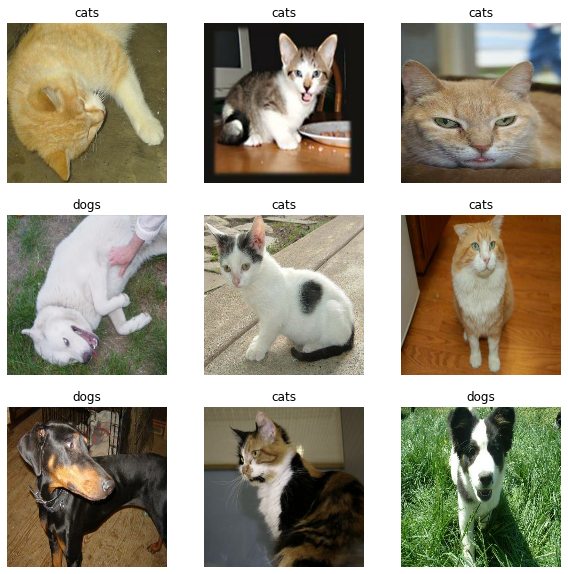

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

`tf.data.experimental.cardinality`を使ってテストデータを作成しています

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


### パフォーマンスの為にデータセットを構成する

この手法の詳細については[データパフォーマンス](https://www.tensorflow.org/guide/data_performance)ガイドをご覧ください。

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### データ拡張

画像の多様化を行っています。

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

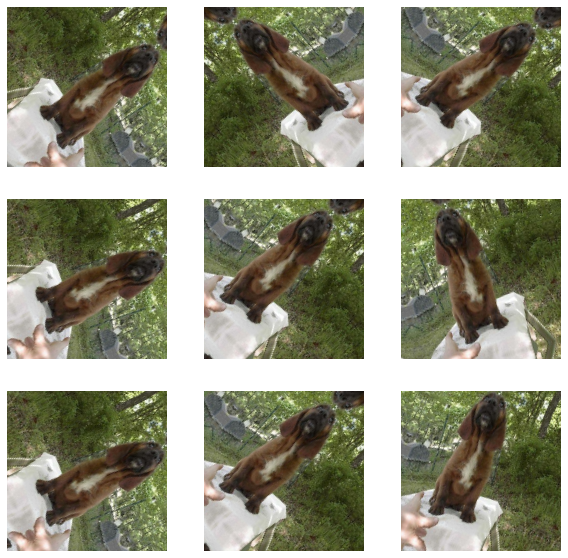

In [ ]:
# データ内容の確認
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### ピクセル値をリスケールする

すぐに`tf.keras.applications.MobileNetV2`をダウンロードして、基本モデルとして使用します。このモデルはピクセル値 [-1,1] を想定していますが、この時点での画像のピクセル値は [0-255] です。ピクセル値のリスケールには、モデルに含まれる前処理のメソッドを使用します。

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

## 既存モデルから基本となるネットワークを構築する

GoogleのMobileNetV2をベースモデルとしています。読み込み時に`include_top=False`とすることで１番上の層を読み込まないと言う指示を与えています。機械学習では一般的に下から上へフィルタリングを行っていく。下の層は一般的で上へいくほど細かなフィルターとなります。

転移学習では元の学習モデルの一番上の層以外の部分を読み込んで、そこに新しい特徴のフィルターを付け足します。

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


この特徴抽出器は、各 `160x160x3` の画像を `5x5x1280` の特徴ブロックに変換します。 これで画像のバッチ例がどうなるかを見てみましょう。

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


## 特徴抽出

このステップでは、前のステップで作成した畳み込みベースを凍結させ、特徴抽出器として使用します。さらに、その上に分類器を追加して、最上位の分類器のトレーニングを行います。

### パラメータ更新の停止

モデルをコンパイルしてトレーニングする前に、`layer.trainable = False `と設定することで、トレーニング中に特定のレイヤーの重みは更新されなくなります。MobileNet V2 には多くのレイヤーがありますが、モデル全体の `trainable` フラグを False に設定することで、全てのレイヤーのパラメータ更新が行われなくなります。

In [ ]:
base_model.trainable = False

### ネットワークの確認

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

### 上位層の追加を行う

ここでは２つの層を追加しています。

１つ目は`global_average_layer`です。`global_average_layer`では元の特徴の平均化を行います。元の学習モデルの特徴量は（5, 5, 1280)でしたので、この5x5分のデータを平均化して1280の特徴にまとめています。

２つ目は`prediction_layer`です。`tf.keras.layers.Dense` レイヤーを適用することで、特徴を画像ごとに単一の予測値に変換します。
通常は引数に活性化関数を指定しますが、今回の場合は指定しないようです、、、？？

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### モデルのコンパイル

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

### 再学習を行う

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 11s 345ms/step - loss: 0.6889 - accuracy: 0.5767


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.69
initial accuracy: 0.58


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 39s 581ms/step - loss: 0.6403 - accuracy: 0.6415 - val_loss: 0.4800 - val_accuracy: 0.7228
Epoch 2/10
63/63 [==============================] - 37s 591ms/step - loss: 0.4751 - accuracy: 0.7385 - val_loss: 0.3614 - val_accuracy: 0.8317
Epoch 3/10
63/63 [==============================] - 37s 591ms/step - loss: 0.3921 - accuracy: 0.8105 - val_loss: 0.2892 - val_accuracy: 0.8713
Epoch 4/10
63/63 [==============================] - 38s 602ms/step - loss: 0.3332 - accuracy: 0.8450 - val_loss: 0.2377 - val_accuracy: 0.9084
Epoch 5/10
63/63 [==============================] - 38s 600ms/step - loss: 0.2889 - accuracy: 0.8705 - val_loss: 0.2032 - val_accuracy: 0.9220
Epoch 6/10
63/63 [==============================] - 38s 598ms/step - loss: 0.2576 - accuracy: 0.8845 - val_loss: 0.1758 - val_accuracy: 0.9406
Epoch 7/10
63/63 [==============================] - 38s 610ms/step - loss: 0.2369 - accuracy: 0.8975 - val_loss: 0.1666 - val_accuracy: 0.9406

### 学習結果をグラフで表示する

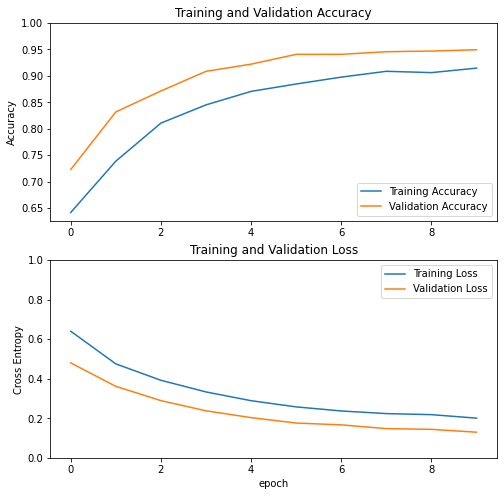

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()